# Time Series Prediction using Dynamic Mode Decomposition

In this tutorial, we will demonstrate the use of the class ``kontrol.dmd.DMD`` for time series prediction using dynamic mode decomposition.
For simplicity, we will model a double decaying oscillation.

$$
y(t) = \mathfrak{Re}\left(a_1e^{(\sigma_1+i\omega_1) t} + a_2e^{\sigma_2 t + i(\omega_2 t+\phi)}\right)\,,
$$
where $a_1=1$, $\sigma_1=-0.2$, $\omega_1=3$, $a_2=4$, $\sigma_2=-0.5$, $\omega_2=6$, and $\phi=7$.

We will generate a time series of 10 seconds.
We use the first 1/2 of the time series to predict the remaining 1/2 of the time series.

Text(0.5, 0, 'Time (s)')

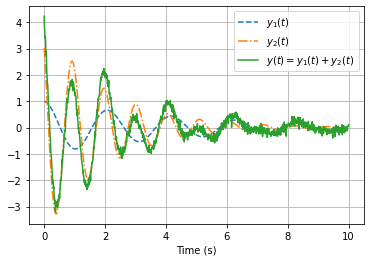

In [271]:
import numpy as np
import matplotlib.pyplot as plt

import kontrol


t = np.linspace(0, 10, 1024)
a1 = 1
sigma_1 = -0.2
omega_1 = 3
a2 = 4
sigma_2 = -0.5
omega_2 = 6
phi = 7
y1 = np.real(a1*np.exp((sigma_1+1j*omega_1)*t))
y2 = np.real(a2*np.exp(sigma_2*t+1j*(omega_2*t+phi)))
y = y1 + y2

# add noise
n = np.random.normal(loc=0, scale=0.1, size=len(y))
y = y+n

plt.plot(t, y1, "--", label="$y_1(t)$")
plt.plot(t, y2, "-.", label="$y_2(t)$")
plt.plot(t, y, label="$y(t) = y_1(t)+y_2(t)$")
plt.legend(loc=0)
plt.grid(which="both")
plt.xlabel("Time (s)")

In [272]:
# Use first half of the data for training.
y_data = y[:512]
y_mean = np.mean(y_data)
# Create a hankel matrix with 128 rows.
snapshot_1 = kontrol.dmd.hankel(y_data, 128)

In [273]:
# Create the DMD instance and use the DMD algorithm to obtain a model.
dmd = kontrol.dmd.DMD(snapshot_1=snapshot_1, run=False)

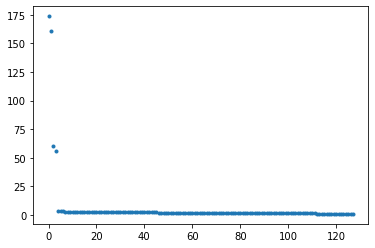

In [274]:
# Several steps but can be simplified later.
# Calculate the SVD of the data matrix
u, sigma, vh = dmd.svd()
# This gives the singular values which could aid the selection of truncation value.

# Plot the singular values
plt.plot(dmd.sigma, ".")

In [283]:
sum(dmd.sigma)

676.1735556529094

In [289]:
(sum(dmd.sigma)-dmd.sigma[4])/sum(dmd.sigma)

0.9955357513877439

From the plot, we see that the dynamics of the time series can be represented by four modes.
Therefore, we can set the truncation value to 4.

In [275]:
dmd.truncation_value = 4
dmd.dt = t[1]-t[0]

ut, sigma_t, vht = dmd.low_rank_approximation()
A_reduced = dmd.compute_reduced_model()
w_reduced, v_reduced = dmd.eig_reduced_model()
dmd_modes = dmd.compute_dmd_modes()
omegas = dmd.compute_complex_frequencies()

# or simply set the truncation value and dt and then run
# dmd.run()

In [280]:
t_predict = t[512:]
y_predict = np.real(dmd.predict(t_predict)[0])

Text(0.5, 0, 'Time (s)')

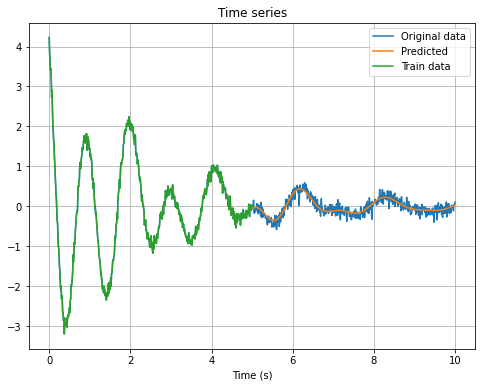

In [282]:
plt.figure(figsize=(8, 6))
plt.title("Time series")
plt.plot(t, y, label="Original data")
plt.plot(t_predict, y_predict, label="Predicted")
plt.plot(t[:512], y_data, label="Train data")
plt.legend(loc=0)
plt.grid(which="both")
plt.xlabel("Time (s)")